# Topic Modeling on Customer Complaints using LDA Algorithm

Summary: This project involves using LDA (Latent Dirichilet Allocation) algorithms to uncover hidden topics from customer complaints data. The complaints data was obtained from Consumer Finance Protection Bureau website (https://www.consumerfinance.gov/data-research/consumer-complaints/) with a focus on credit card products.

Results: The model was used to categorize customer complaints into more accurate and intuitive categories, reducing rerouting of complaints and uncovering hiddent themes in the data.
    
Python Libraries used: Numpy, Pandas, NLTK, SpaCy, Gensim, Mallet, pyLDAvis

# Step 1: Download Credit Card Complaints Data from CFPB website 

The Consumer Financial Protection Bureau (CFPB) is a U.S. government agency that makes sure banks, lenders, and other financial companies treat all customers fairly. The CFPB was created to provide a single point of accountability for enforcing federal consumer financial laws and protecting consumers in the financial marketplace. It provides a platform to register customer complaints for customer advocacy and quick resolution. For this project, I focussed on 18K customer complaints focussing on credit card products.

# Step 2: Import Complaints Data

In [22]:
# Import Numpy and Pandas Python Libraries
import numpy as np
import pandas as pd
from pprint import pprint
import re

# Import Gensim for Topic Modeling
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Import spacy for lemmatization
import spacy

# Import pyLDAvis for plotting topics
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#Import NLTK and Stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')
stopwords.extend(['from', 'subject', 're', 'edu', 'use', 'xxxx', 'xxx', 'xx', 'x'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vishalmorde/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Import complaints data from Consumer Finance Protection Bureau website (https://www.consumerfinance.gov/data-research/consumer-complaints/) 
# The complaints on credit card products were retained in the dataset (~18K)
df1 = pd.read_csv('./complaints_2019_05_01_23_05.csv')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18838 entries, 0 to 18837
Data columns (total 18 columns):
Date received                   18838 non-null object
Product                         18838 non-null object
Sub-product                     18838 non-null object
Issue                           18838 non-null object
Sub-issue                       18838 non-null object
Consumer complaint narrative    18838 non-null object
Company public response         18838 non-null object
Company                         18838 non-null object
State                           18838 non-null object
ZIP code                        18838 non-null object
Tags                            18838 non-null object
Consumer consent provided?      18838 non-null object
Submitted via                   18838 non-null object
Date sent to company            18838 non-null object
Company response to consumer    18838 non-null object
Timely response?                18838 non-null object
Consumer disputed?         

In [3]:
df1.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,12/26/16,Credit card,None,Delinquent account,None,Discover card was paid almost 2 years ago and ...,None,DISCOVER BANK,UT,840XX,None,Consent provided,Web,12/26/16,Closed with explanation,Yes,No,2263945
1,12/26/16,Credit card,None,Identity theft / Fraud / Embezzlement,None,I got notice on XXXX/XXXX/16 that there was su...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",WA,980XX,None,Consent provided,Web,12/26/16,Closed with monetary relief,Yes,No,2263862
2,12/26/16,Credit card,None,Billing disputes,None,I have a Discover card that has not been used ...,None,DISCOVER BANK,GA,310XX,None,Consent provided,Web,12/26/16,Closed with explanation,Yes,No,2263670
3,12/25/16,Credit card,None,Advertising and marketing,None,on XX/XX/2016 I went into Walmart to purchase ...,Company has responded to the consumer and the ...,SYNCHRONY FINANCIAL,AZ,853XX,None,Consent provided,Web,12/25/16,Closed with explanation,Yes,No,2263407
4,12/25/16,Credit card,None,Billing disputes,None,I issued a dispute for a charge of {$350.00} w...,None,FIFTH THIRD FINANCIAL CORPORATION,TX,750XX,None,Consent provided,Web,12/25/16,Closed with explanation,Yes,Yes,2263528


In [4]:
# Only keep columns with complaint narratives (unstructured text data)
df = df1[['Issue', 'Consumer complaint narrative']]

In [5]:
df.rename(columns={'Issue':'issue', 'Consumer complaint narrative':'narrative'}, inplace=True)
df.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,issue,narrative
0,Delinquent account,Discover card was paid almost 2 years ago and ...
1,Identity theft / Fraud / Embezzlement,I got notice on XXXX/XXXX/16 that there was su...
2,Billing disputes,I have a Discover card that has not been used ...
3,Advertising and marketing,on XX/XX/2016 I went into Walmart to purchase ...
4,Billing disputes,I issued a dispute for a charge of {$350.00} w...


In [6]:
df['issue'].value_counts()

Billing disputes                            3102
Other                                       1940
Identity theft / Fraud / Embezzlement       1723
Closing/Cancelling account                  1440
Customer service / Customer relations        973
Rewards                                      900
Delinquent account                           834
Advertising and marketing                    818
APR or interest rate                         785
Late fee                                     771
Credit card protection / Debt protection     712
Transaction issue                            681
Billing statement                            620
Payoff process                               513
Credit determination                         506
Other fee                                    502
Unsolicited issuance of credit card          491
Credit line increase/decrease                451
Balance transfer                             298
Application processing delay                 107
Privacy             

# Step 3: Pre-processing of data

In [36]:
# Basic pre processing
import re
def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("</?.*?>"," <> ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    return text

df['narrative'] = df['narrative'].apply(lambda x:pre_process(x))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [37]:
# Convert to list
data = df.narrative.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['discover card was paid almost years ago and they continue to update monthly '
 'and damage my credit it is affecting my financing and they are in violation '
 'of the fcra ']


In [39]:
# Create a list of all words in the dataset
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [40]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['discover', 'card', 'was', 'paid', 'almost', 'years', 'ago', 'and', 'they', 'continue', 'to', 'update', 'monthly', 'and', 'damage', 'my', 'credit', 'it', 'is', 'affecting', 'my', 'financing', 'and', 'they', 'are', 'in', 'violation', 'of', 'the', 'fcra']


In [41]:
# Define functions for removing stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stopwords] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, 
                  allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc 
                          if token.pos_ in allowed_postags])
    return texts_out

In [44]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops , 
                  allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['discover', 'card', 'pay', 'almost', 'year', 'ago', 'continue', 'update', 'monthly', 'damage', 'credit', 'affect', 'financing', 'violation', 'fcra']]


# Step 4: Create the Dictionary and Corpus needed for Topic Modeling

In [45]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]]


In [ ]:
#This is used as the input by the LDA model.
#If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [48]:
id2word[10]

'monthly'

In [49]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('affect', 1),
  ('ago', 1),
  ('almost', 1),
  ('card', 1),
  ('continue', 1),
  ('credit', 1),
  ('damage', 1),
  ('discover', 1),
  ('fcra', 1),
  ('financing', 1),
  ('monthly', 1),
  ('pay', 1),
  ('update', 1),
  ('violation', 1),
  ('year', 1)]]

# Step 5: Building LDA Model using Gensim

In [50]:
# Import Gensim Library
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [51]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.065*"point" + 0.058*"offer" + 0.049*"express" + 0.047*"american" + '
  '0.036*"card" + 0.035*"reward" + 0.033*"amex" + 0.030*"bonus" + '
  '0.027*"spend" + 0.023*"apply"'),
 (1,
  '0.115*"card" + 0.099*"account" + 0.080*"credit" + 0.046*"bank" + '
  '0.016*"close" + 0.015*"never" + 0.014*"year" + 0.012*"new" + 0.012*"issue" '
  '+ 0.011*"open"'),
 (2,
  '0.071*"chase" + 0.034*"transaction" + 0.028*"purchase" + 0.026*"merchant" + '
  '0.022*"refund" + 0.021*"return" + 0.017*"item" + 0.015*"order" + '
  '0.012*"term" + 0.012*"claim"'),
 (3,
  '0.060*"discover" + 0.019*"paypal" + 0.019*"home" + 0.012*"store" + '
  '0.011*"citicard" + 0.011*"car" + 0.011*"work" + 0.010*"job" + '
  '0.010*"merchandise" + 0.009*"power"'),
 (4,
  '0.102*"payment" + 0.067*"pay" + 0.056*"balance" + 0.043*"interest" + '
  '0.038*"make" + 0.036*"month" + 0.034*"due" + 0.024*"amount" + '
  '0.022*"statement" + 0.016*"date"'),
 (5,
  '0.053*"call" + 0.037*"would" + 0.035*"tell" + 0.027*"get" + 0.026*"say"

In [53]:
# Compute Perplexity, a measure of how good the model is (lower the better)
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.659294241240587

Coherence Score:  0.4215954870829127


In [71]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
5      24.673124        1       1 -0.029335  0.161835
1      21.829613        1       2 -0.021494  0.011445
4      13.651493        1       3 -0.256735 -0.020232
7       9.776596        1       4  0.079581  0.216711
2       6.607839        1       5 -0.026258  0.104046
8       5.968140        1       6 -0.198477 -0.042695
6       5.135805        1       7  0.103394 -0.208970
9       4.762791        1       8  0.271500  0.165539
0       4.106476        1       9 -0.131753 -0.101726
3       3.488114        1      10  0.209576 -0.285953, topic_info=     Category          Freq         Term         Total  loglift  logprob
term                                                                    
5     Default  46915.000000       credit  46915.000000  30.0000  30.0000
3     Default  44054.000000         card  44054.000000  29.0000  29.0000
34    Default  20646.000000       charge  20646.000000  28.0000  28.0000
15    Default  35690.000000      account  35690.000000  27.0000  27.0000
379   Default  23007.000000      payment  23007.000000  26.0000  26.0000
95    Default  10841.000000       report  10841.000000  25.0000  25.0000
50    Default  11193.000000          fee  11193.000000  24.0000  24.0000
30    Default  21691.000000         call  21691.000000  23.0000  23.0000
11    Default  18535.000000          pay  18535.000000  22.0000  22.0000
528   Default  12707.000000      balance  12707.000000  21.0000  21.0000
27    Default  16491.000000         bank  16491.000000  20.0000  20.0000
376   Default   8586.000000         late   8586.000000  19.0000  19.0000
286   Default   7761.000000        chase   7761.000000  18.0000  18.0000
110   Default  14392.000000         tell  14392.000000  17.0000  17.0000
133   Default   9808.000000     interest   9808.000000  16.0000  16.0000
28    Default   6608.000000         bill   6608.000000  15.0000  15.0000
148   Default   8589.000000    statement   8589.000000  14.0000  14.0000
57    Default  11019.000000          get  11019.000000  13.0000  13.0000
420   Default   5011.000000      capital   5011.000000  12.0000  12.0000
98    Default  10822.000000          say  10822.000000  11.0000  11.0000
410   Default  11012.000000        month  11012.000000  10.0000  10.0000
516   Default   4752.000000        point   4752.000000   9.0000   9.0000
197   Default  17257.000000        would  17257.000000   8.0000   8.0000
182   Default   5023.000000        offer   5023.000000   7.0000   7.0000
181   Default   6550.000000       number   6550.000000   6.0000   6.0000
229   Default   6718.000000       letter   6718.000000   5.0000   5.0000
320   Default   8238.000000          due   8238.000000   4.0000   4.0000
73    Default  14366.000000         make  14366.000000   3.0000   3.0000
44    Default   6668.000000      dispute   6668.000000   2.0000   2.0000
841   Default   4491.000000         citi   4491.000000   1.0000   1.0000
...       ...           ...          ...           ...      ...      ...
2252  Topic10    363.855255  reservation    364.742676   3.3534  -5.0695
1917  Topic10    348.366943       repair    349.254425   3.3533  -5.1130
2085  Topic10    344.472565         area    345.360199   3.3532  -5.1243
2238  Topic10    342.576294      expense    343.463837   3.3532  -5.1298
354   Topic10    318.358917           tv    319.246521   3.3530  -5.2031
1939  Topic10    303.478058      failure    304.365631   3.3529  -5.2510
347   Topic10    268.506683     property    269.394226   3.3525  -5.3734
3112  Topic10    263.486328          gas    264.373718   3.3524  -5.3923
1947  Topic10    250.287735         rent    251.175140   3.3523  -5.4437
2076  Topic10    240.086441         hsbc    240.973785   3.3521  -5.4853
2209  Topic10    227.560989         shop    228.448532   3.3519  -5.5388
1852  Topic10    225.992432       laptop    226.880096   3.3519  -5.5458
1658  Topic10    224.550

# Step 6: Building LDA Mallet Model

In [62]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/vishalmorde/Desktop/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [63]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('call', 0.13750916306463437),
   ('phone', 0.03929374889411289),
   ('receive', 0.03459214883344708),
   ('speak', 0.028595081014130077),
   ('number', 0.02809585197543035),
   ('customer', 0.025650261621293698),
   ('service', 0.0256249842016127),
   ('time', 0.024474861606127246),
   ('day', 0.022332600288162585),
   ('representative', 0.019691109931498193)]),
 (1,
  [('report', 0.053462462681133034),
   ('information', 0.050360445641884515),
   ('account', 0.04029709458967451),
   ('letter', 0.037384402534042085),
   ('send', 0.028930313842568993),
   ('debt', 0.02611956600888371),
   ('file', 0.019587854074128015),
   ('address', 0.018728609917716448),
   ('credit', 0.018218888807980775),
   ('state', 0.018007718633947425)]),
 (2,
  [('payment', 0.16324574939579062),
   ('fee', 0.07463307051105897),
   ('make', 0.06741074259623311),
   ('late', 0.0635353471297412),
   ('due', 0.05444578321742378),
   ('pay', 0.042220672064035625),
   ('bill', 0.03755610515709444),
   ('sta

In [64]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.40370324019877624


In [ ]:
# Mallet library seems show better coherence score than standard Gensim LDA library

# Step 7: Find the optimal number of topics for LDA

In [65]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [66]:
# Run for different k values
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=2, limit=40, step=6)

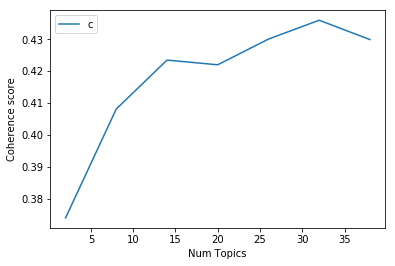

In [67]:
# Show Cohence Score by different k values 
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [68]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.374
Num Topics = 8  has Coherence Value of 0.4081
Num Topics = 14  has Coherence Value of 0.4235
Num Topics = 20  has Coherence Value of 0.422
Num Topics = 26  has Coherence Value of 0.43
Num Topics = 32  has Coherence Value of 0.4359
Num Topics = 38  has Coherence Value of 0.4299


# Step 8: Select the final model and print the topics

In [73]:
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(12,
  '0.109*"fee" + 0.095*"card" + 0.040*"cancel" + 0.036*"barclay" + '
  '0.033*"annual" + 0.030*"visa" + 0.027*"benefit" + 0.019*"year" + '
  '0.017*"ticket" + 0.017*"travel"'),
 (9,
  '0.120*"dispute" + 0.048*"provide" + 0.043*"merchant" + 0.042*"claim" + '
  '0.033*"return" + 0.023*"order" + 0.023*"item" + 0.022*"case" + '
  '0.019*"documentation" + 0.017*"document"'),
 (16,
  '0.202*"report" + 0.170*"credit" + 0.058*"remove" + 0.049*"information" + '
  '0.044*"account" + 0.028*"reporting" + 0.025*"bureau" + 0.025*"agency" + '
  '0.021*"correct" + 0.020*"show"'),
 (19,
  '0.185*"balance" + 0.172*"interest" + 0.061*"transfer" + 0.055*"rate" + '
  '0.036*"month" + 0.032*"fargo" + 0.025*"apply" + 0.023*"pay" + 0.022*"high" '
  '+ 0.019*"amount"'),
 (4,
  '0.164*"statement" + 0.102*"date" + 0.076*"due" + 0.064*"day" + '
  '0.039*"change" + 0.034*"show" + 0.030*"billing" + 0.026*"online" + '
  '0.025*"receive" + 0.023*"make"'),
 (3,
  '0.212*"call" + 0.074*"phone" + 0.066*"speak" + 0

# Step 9: Find the dominant topic in each sentence

In [74]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,16.0,0.0700,"report, credit, remove, information, account, ...",discover card was paid almost years ago and th...
1,1,3.0,0.1252,"call, phone, speak, supervisor, number, back, ...",i got notice on xxxx xxxx that there was suspe...
2,2,25.0,0.1126,"contact, request, issue, resolve, complaint, a...",i have a discover card that has not been used ...
3,3,21.0,0.0976,"fraud, information, number, address, security,...",on xx xx i went into walmart to purchase xx xx...
4,4,9.0,0.2156,"dispute, provide, merchant, claim, return, ord...",i issued a dispute for a charge of with fifth ...
5,5,25.0,0.0713,"contact, request, issue, resolve, complaint, a...",my account ending in xxxx had fraud on it and ...
6,6,8.0,0.1129,"chase, card, credit, apply, application, deny,...",i applied for a visa using a third part servic...
7,7,5.0,0.1921,"purchase, make, cash, good, store, buy, home, ...",i called the xxxx they quickly transferred me ...
8,8,14.0,0.0930,"credit, limit, score, line, inquiry, increase,...",this week xxxx i received xxxx letters from ba...
9,9,20.0,0.1492,"express, american, card, time, amex, business,...",i am two months behind in my american express ...


# Step 10: Find the most representative document for each topic

In [77]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Print
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2464,"charge, transaction, fraudulent, make, authori...",i asked for a quote on lights from xxxx xxxx o...
1,1.0,0.2943,"account, close, open, citibank, closed, notice...",i attempted to use my jcpenney credit card on ...
2,2.0,0.2481,"customer, service, citi, time, online, issue, ...",back on xxxx xxxx i used my easy deal points w...
3,3.0,0.3673,"call, phone, speak, supervisor, number, back, ...",to whom it may concern i contacted citi bank o...
4,4.0,0.3122,"statement, date, due, day, change, show, billi...",i am alleging discrimination by discover card ...
5,5.0,0.4649,"purchase, make, cash, good, store, buy, home, ...",i applied for a home depot credit card under a...
6,6.0,0.5037,"company, website, find, work, car, sign, conta...",in xx xx xxxx we purchased granite tile from t...
7,7.0,0.3556,"payment, late, make, fee, due, month, minimum,...",continental finance company took advantage of ...
8,8.0,0.5082,"chase, card, credit, apply, application, deny,...",i previously filed a complaint case number xxx...
9,9.0,0.4595,"dispute, provide, merchant, claim, return, ord...",i disputed a charge on my bank of america cred...


# Step 11: Topic distribution across documents

In [80]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Print
df_dominant_topics.head(10)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,16.0,"report, credit, remove, information, account, ...",657.0,0.0349
1,3.0,"call, phone, speak, supervisor, number, back, ...",792.0,0.0420
2,25.0,"contact, request, issue, resolve, complaint, a...",392.0,0.0208
3,21.0,"fraud, information, number, address, security,...",884.0,0.0469
4,9.0,"dispute, provide, merchant, claim, return, ord...",524.0,0.0278
5,25.0,"contact, request, issue, resolve, complaint, a...",574.0,0.0305
6,8.0,"chase, card, credit, apply, application, deny,...",465.0,0.0247
7,5.0,"purchase, make, cash, good, store, buy, home, ...",1388.0,0.0737
8,14.0,"credit, limit, score, line, inquiry, increase,...",562.0,0.0298
9,20.0,"express, american, card, time, amex, business,...",862.0,0.0458
